# Perform some initial analysis on the results of the SnapATAC2 pipeline
**Authorship:** Adam Klie (last updated: 08/22/2023)<br>
***
**Description:** Notebook to plot and plan next steps from a baseline SnapATAC2 run. Expects that you have run all steps up to and including `7_analyze_anndataset.sh`. This is somewhat of a playground and thus will need to be interactive.

# Set-up

In [1]:
# Import packages
import os
import numpy as np
import pandas as pd
import snapatac2 as snap
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr

In [2]:
# Paths
sample = "MO1"
input_h5ad_path = f"/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/16Aug23/snapatac2/processed/adata_atac_{sample}_processed.h5ad"
input_rna_metadata_path = f"/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/20Oct23/H1_control/{sample.lower()}/rna/annotate/annotate_metadata.tsv"
#input_rna_metadata_path = f"/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/21Oct23/A2_control/{sample.lower()}/rna/annotate/annotate_metadata.tsv"
outdir_path = f"/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/16Aug23/snapatac2/annotated/{sample.lower()}/adata_atac_{sample}_annotated.h5ad"

In [3]:
# If output directory does not exist, create it
if not os.path.exists(os.path.dirname(outdir_path)):
    os.makedirs(os.path.dirname(outdir_path))

# Load the data

In [4]:
# Load h5ad
adata = sc.read_h5ad(input_h5ad_path)
adata

AnnData object with n_obs × n_vars = 2780 × 606219
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'scrublet_sim_doublet_score'
    obsm: 'insertion'

In [5]:
# Load in RNA annotations
rna_annot = pd.read_csv(input_rna_metadata_path, sep="\t", index_col=0)
rna_annot.head()

,total_counts,pct_counts_mt,annotate_clustering,manual_cellid_annotation
AAACAGCCAAAGGTAC-1,8767.0,0.581727,3,SC.beta
AAACAGCCACCTACTT-1,4636.0,0.064711,1,SC.EC
AAACAGCCAGCAATAA-1,7781.0,0.025704,2,SC.alpha
AAACCAACAACCGCCA-1,5564.0,0.000000,10,SC.delta
AAACCGCGTATTGTGG-1,9338.0,0.021418,2,SC.alpha


In [6]:
# Add RNA annotations
adata.obs = adata.obs.merge(rna_annot, left_index=True, right_index=True, how="left", suffixes=("_atac", "_rna"))
adata.obs["manual_cellid_annotation"].value_counts()

SC.beta                 979
SC.EC                   857
SC.alpha                473
SC.delta                 50
endocrine_progenitor     49
proliferating_alpha      29
Name: manual_cellid_annotation, dtype: int64

In [7]:
# Save h5ad with annotations
#adata.write(outdir_path)

# Process single sample with SnapATAC2

In [8]:
# Drop cells with n_fragment > 60k
adata = adata[adata.obs["n_fragment"] < 60000, :]

In [9]:
# Run spectral dimensionality reduction
snap.tl.spectral(adata)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/snapatac2/tools/_embedding.py:253: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['spectral_eigenvalue'] = evals


In [10]:
# Remove the first dimension of the spectral embedding
adata.obsm['X_spectral'] = np.delete(adata.obsm['X_spectral'], [0], axis=1)

In [11]:
# Run UMAP
snap.tl.umap(adata)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cellar/users/aklie/opt/mi

In [12]:
# Make kNN graph
snap.pp.knn(adata)

In [13]:
# Run Leiden clustering
snap.tl.leiden(adata)

... storing 'manual_cellid_annotation' as categorical
... storing 'leiden' as categorical


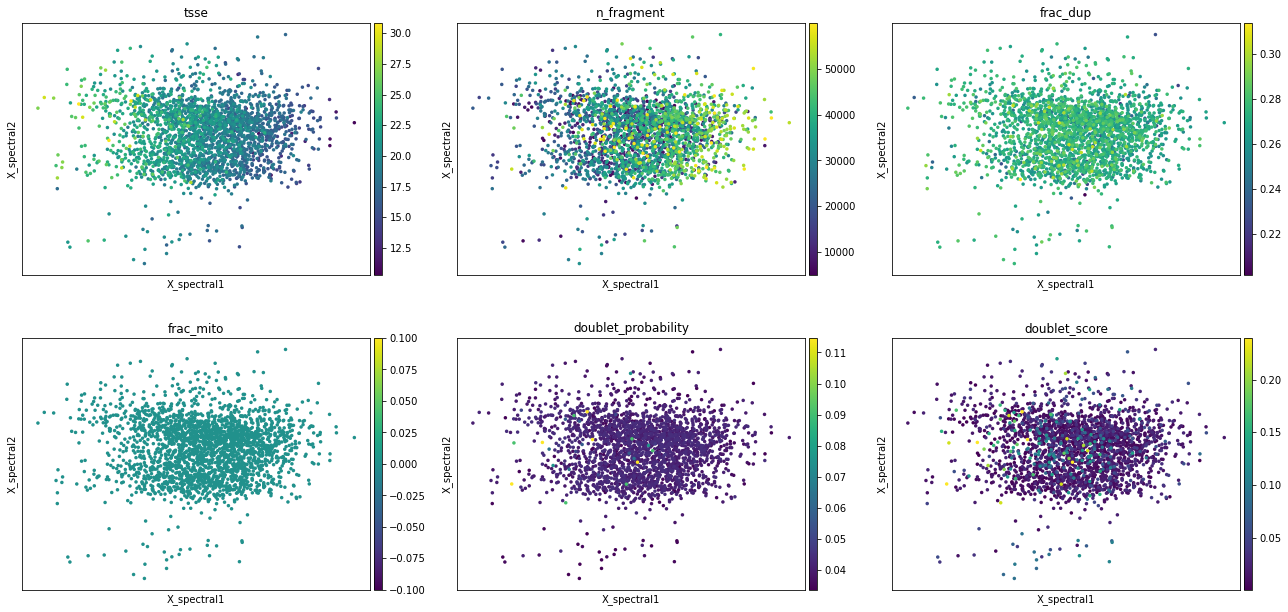

In [14]:
sc.pl.embedding(adata, basis="X_spectral", color=['tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score'], ncols=3)

In [15]:
# Create a matrix of correlations between technical covariates and the first axis of each reduction
technical_covariates = ["tsse", "n_fragment", "frac_dup", "frac_mito", "doublet_probability", "doublet_score"]
spearman_corrs_dim = {}
pearson_corrs_dim = {}
spearman_ps_dim = {}
pearson_ps_dim = {}
for dim in np.arange(0, 5):
    spearman_corrs = pd.DataFrame()
    pearson_corrs = pd.DataFrame()
    spearman_ps = pd.DataFrame()
    pearson_ps = pd.DataFrame()
    for reduction in ["X_spectral"]:
        if reduction in adata.obsm.keys():
            if "umap" in reduction:
                continue
            for covariate in technical_covariates:
                corr, p = spearmanr(adata.obsm[reduction][:, dim], adata.obs[covariate])
                spearman_corrs.loc[reduction, covariate] = corr
                spearman_ps.loc[reduction, covariate] = p
                corr, p = pearsonr(adata.obsm[reduction][:, dim], adata.obs[covariate])
                pearson_corrs.loc[reduction, covariate] = corr
                pearson_ps.loc[reduction, covariate] = p
        else:
            print(f"{reduction} not in adata.obsm.keys()")
    spearman_corrs_dim[dim] = spearman_corrs
    spearman_ps_dim[dim] = spearman_ps
    pearson_corrs_dim[dim] = pearson_corrs
    pearson_ps_dim[dim] = pearson_ps

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.

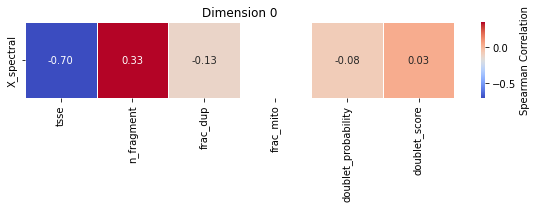

In [17]:
order = ["X_spectral"]
dim_to_plot = 0
df_heatmap = pd.DataFrame(spearman_corrs_dim[dim_to_plot]).loc[order]

plt.figure(figsize=(8, 3))
sns.heatmap(df_heatmap, cmap="coolwarm", annot=True, fmt=".2f", linewidths=1, linecolor="white", cbar_kws={"label": "Spearman Correlation"})
plt.title(f"Dimension {dim_to_plot}")
plt.tight_layout()
plt.show()

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


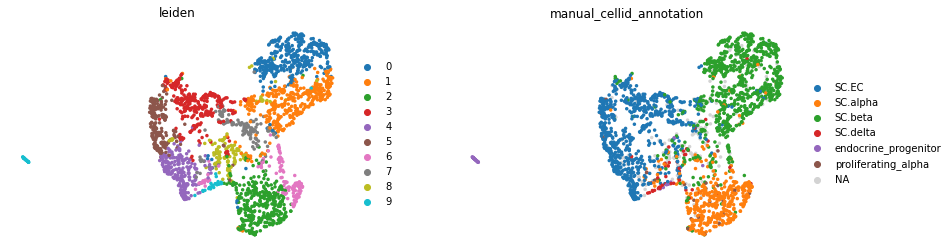

In [18]:
sc.pl.umap(adata, color=["leiden", "manual_cellid_annotation"], frameon=False, wspace=0.2)

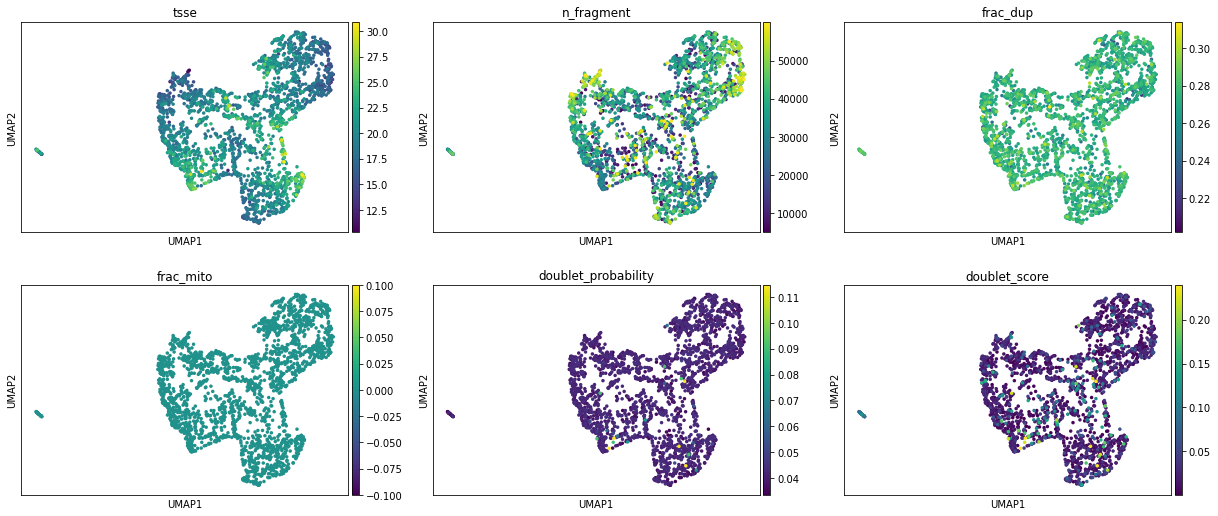

In [19]:
sc.pl.umap(adata, color=['tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score'], ncols=3)

# DONE!

---